# **XAI for Best Classifier (gbm)**

Main goal of this notebook is to try to explain decisions made by Gradient Boosting Machine classifier in out binary classification task

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [67]:
# load data
train_df = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_df = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

# Load the model
best_model = joblib.load('../TASK_4/best_models/gbm.pkl')

In [68]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data = train_df.drop(columns=columns_to_drop, inplace=False)
test_data = test_df.drop(columns=columns_to_drop, inplace=False)
train_data = train_data[:400]
train_labels = train_labels[:400]
test_data = test_data[:400]
test_labels = test_labels[:400]

In [69]:
train_prediction = best_model.predict(train_data)
test_prediction = best_model.predict(test_data)

validation = classification_report(test_labels, test_prediction, output_dict=True)
pd.DataFrame(validation).transpose()

,precision,recall,f1-score,support
0,0.927083,0.778426,0.846276,343.0000
1,0.321429,0.631579,0.426036,57.0000
accuracy,0.757500,0.757500,0.757500,0.7575
macro avg,0.624256,0.705002,0.636156,400.0000
weighted avg,0.840778,0.757500,0.786392,400.0000


In [70]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_prediction

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_prediction

explanations = dict()

## **GBM Feature Importance**

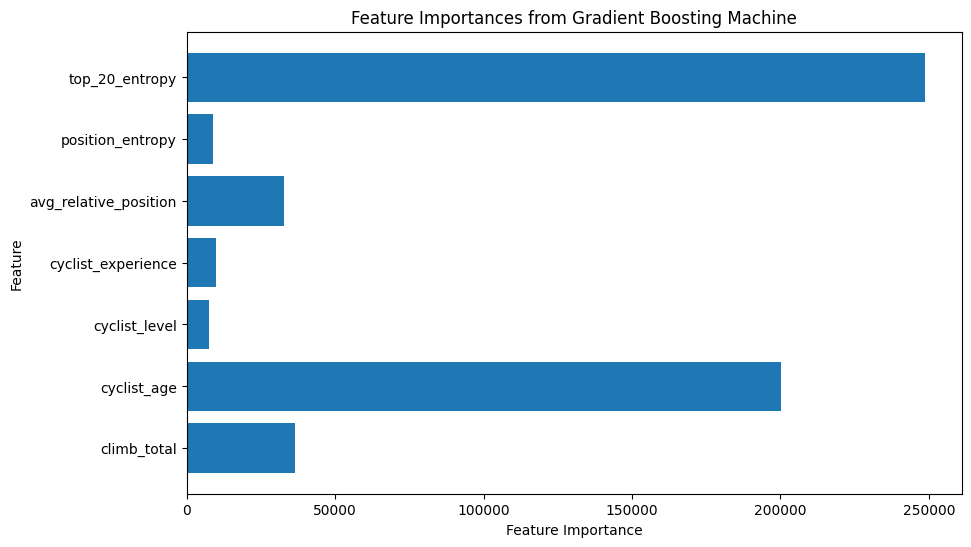

In [71]:
import matplotlib.pyplot as plt

gbm_model = best_model.named_steps['clf']

# Print feature importance
feature_importances = gbm_model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(train_data.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting Machine')
plt.show()

In [72]:
print("gbm feture importance:")
for feature, importance in zip(train_data.columns, feature_importances):
    print(f"{feature}: {importance}")

gbm feture importance:
climb_total: 36338.73665381968
cyclist_age: 200057.82809996605
cyclist_level: 7410.736044220626
cyclist_experience: 9882.760590434074
avg_relative_position: 32676.535688221455
position_entropy: 9019.091836452484
top_20_entropy: 248606.06138264015


Recalling this is importance coming from GBM library

## **SHAP**

In [73]:
import shap

In [74]:
# Extract the underlying model from the pipeline
gbm_model = best_model.named_steps['clf']

interventional_explanation_algorithm = shap.TreeExplainer(
    model=gbm_model,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=gbm_model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)


In [75]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

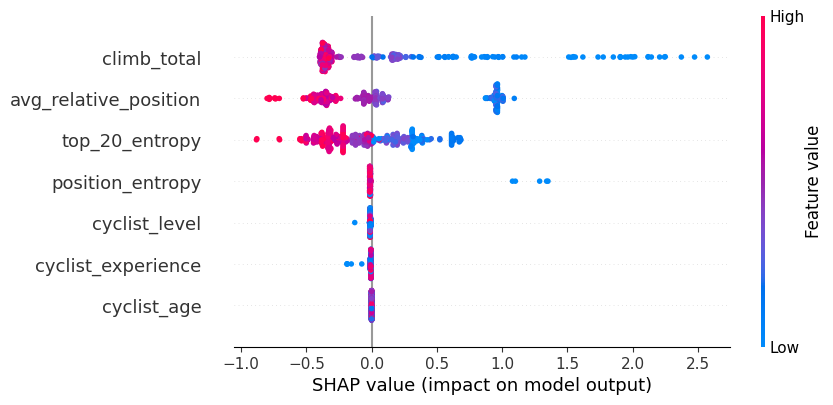

In [76]:
shap.plots.beeswarm(interventional_explanations)

The plot shows that `climb_total` and `avg_relative_position` have the strongest influence on predictions, with high climb totals contributing positively. Features like `cyclist_level` and `cyclist_experience` show less impact, while `cyclist_age` has minimal influence.

The discrepancy arises because GBM importance measures feature impact based on split frequency and impurity reduction, favoring features like `top_20_entropy`, while SHAP evaluates individual prediction contributions, offering a more balanced perspective.

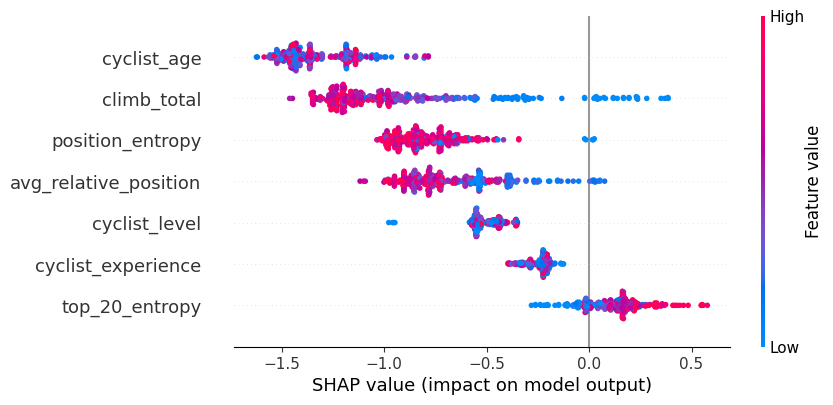

In [77]:
shap.plots.beeswarm(distributional_explanations)

Here’s a concise feature-by-feature summary of the SHAP plot:

1. **Cyclist Age**: Older cyclists (red) have a **negative impact** on the model’s output.
2. **Climb Total**: More climbs (red) are associated with **worse predictions** (negative SHAP values).
3. **Position Entropy**: Higher entropy (red) leads to **negative SHAP values**, indicating uncertainty in position hurts predictions.
4. **Average Relative Position**: Better positions (blue) correspond to **positive SHAP values**, predicting better performance.
5. **Cyclist Level**: Higher levels (red) lead to **positive SHAP values**, indicating better performance predictions.
6. **Cyclist Experience**: More experience (red) correlates with **negative SHAP values**, predicting worse outcomes.
7. **Top 20 Entropy**: Higher entropy (red) results in **negative SHAP values**, suggesting uncertainty in top rankings decreases predictions.

Overall, features like **cyclist level** and **relative position** show positive impacts, while **age**, **climb total**, and **experience** correlate with negative impacts.

In [78]:
print("Features sorted by decreasing importance for interventional method:")
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
print(interventional_explanations_df.abs().mean().sort_values(ascending=False))

print("\nFeatures sorted by decreasing importance for distributional method:")
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=train_data.columns.tolist())
print(distributional_explanations_df.abs().mean().sort_values(ascending=False))

Features sorted by decreasing importance for interventional method:
climb_total              0.458192
avg_relative_position    0.437380
top_20_entropy           0.267997
position_entropy         0.027216
cyclist_level            0.010378
cyclist_experience       0.008254
cyclist_age              0.000000
dtype: float64

Features sorted by decreasing importance for distributional method:
cyclist_age              1.341477
climb_total              0.957987
position_entropy         0.798736
avg_relative_position    0.674212
cyclist_level            0.506228
cyclist_experience       0.240648
top_20_entropy           0.145558
dtype: float64


Let's analyze feature importance according to shap values


Features sorted by decreasing importance for interventional method:


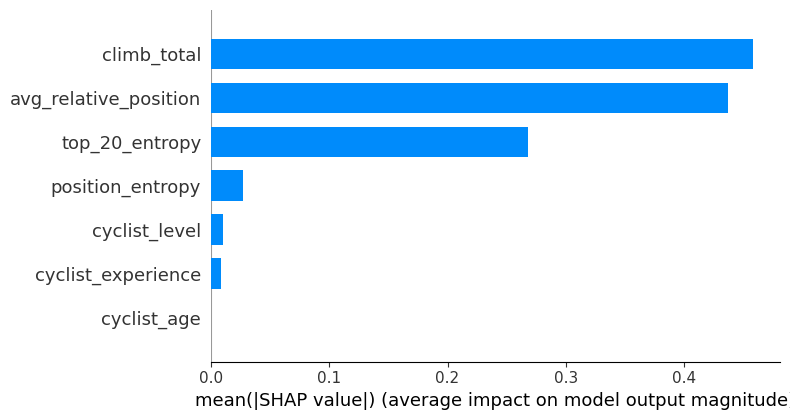


Features sorted by decreasing importance for distributional method:


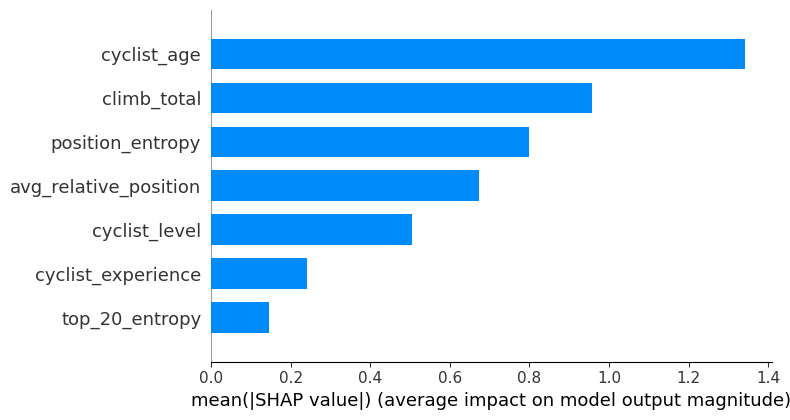

In [79]:
print("\nFeatures sorted by decreasing importance for interventional method:")
shap.summary_plot(interventional_explanations, test_data, plot_type="bar")
print("\nFeatures sorted by decreasing importance for distributional method:")
shap.summary_plot(distributional_explanations, test_data, plot_type="bar")

In [80]:
print("Features sorted by decreasing importance for interventional method:")
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
print(interventional_explanations_df.abs().mean().sort_values(ascending=False))

print("\nFeatures sorted by decreasing importance for distributional method:")
distributional_explanations_df = pd.DataFrame(distributional_explanations.values, columns=train_data.columns.tolist())
print(distributional_explanations_df.abs().mean().sort_values(ascending=False))

Features sorted by decreasing importance for interventional method:
climb_total              0.458192
avg_relative_position    0.437380
top_20_entropy           0.267997
position_entropy         0.027216
cyclist_level            0.010378
cyclist_experience       0.008254
cyclist_age              0.000000
dtype: float64

Features sorted by decreasing importance for distributional method:
cyclist_age              1.341477
climb_total              0.957987
position_entropy         0.798736
avg_relative_position    0.674212
cyclist_level            0.506228
cyclist_experience       0.240648
top_20_entropy           0.145558
dtype: float64


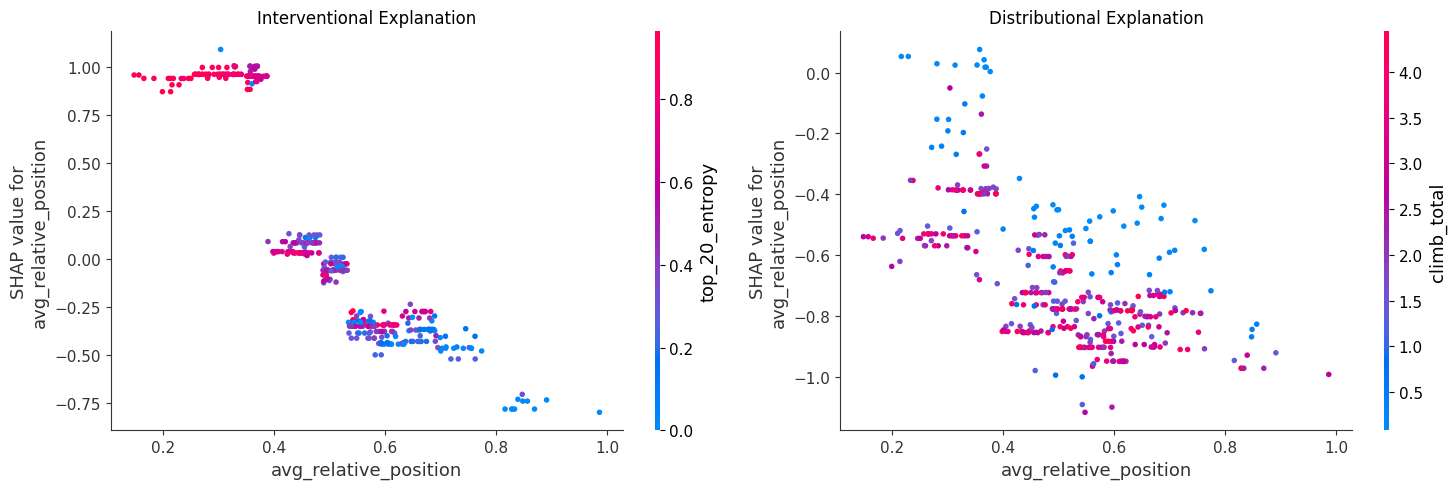

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

shap.dependence_plot("avg_relative_position", explanations["shap_interventional"], test_data, ax=ax[0], show=False)
ax[0].set_title('Interventional Explanation')

shap.dependence_plot("avg_relative_position", explanations["shap_distributional"], test_data, ax=ax[1], show=False)
ax[1].set_title('Distributional Explanation')

plt.tight_layout()
plt.show()

The results show a positive correlation between `top_20_entropy` and the SHAP values of `avg_relative_position`, with higher entropy values tending to lead to higher SHAP values. On the other hand, the `climb_total` variable appears to have a negative relationship with `avg_relative_position`, as higher `climb_total` values are associated with lower SHAP values. These results suggest that `top_20_entropy` has a positive influence on the model, while `climb_total` has a negative effect on the prediction of `avg_relative_position`.

### Let's visualize some decisions made one sample for classe with different explainer

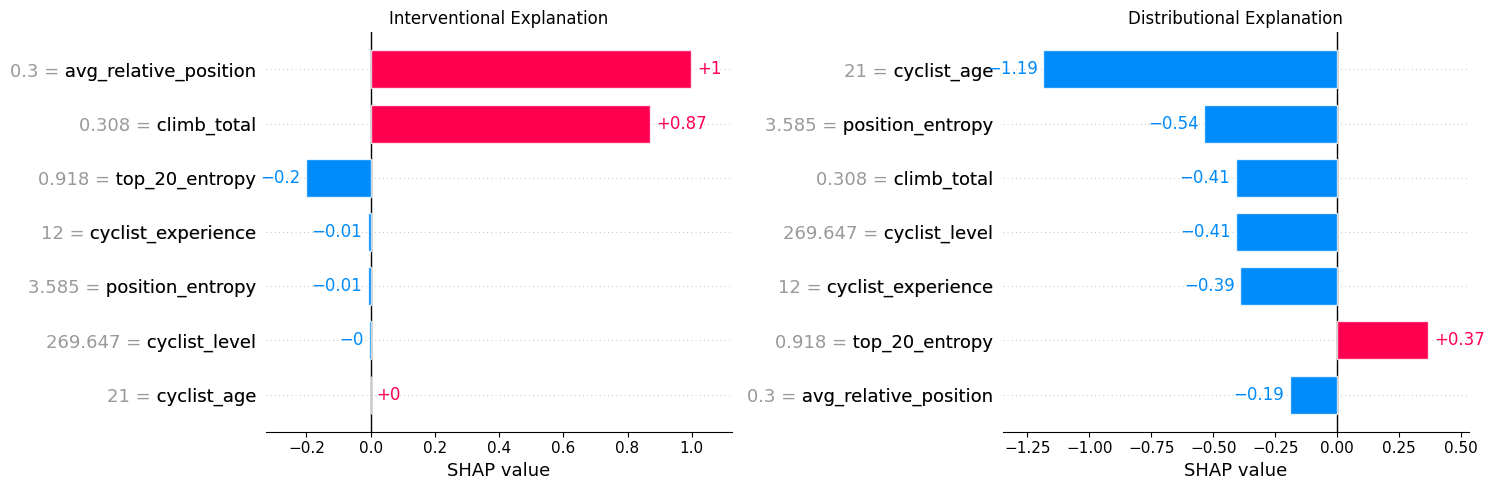

Predicted value: 1
Real value: 1


In [82]:
instance_index = 261
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

shap.plots.bar(interventional_explanations[instance_index], show=False, ax=ax[0])
ax[0].set_title('Interventional Explanation')

shap.plots.bar(distributional_explanations[instance_index], show=False, ax=ax[1])
ax[1].set_title('Distributional Explanation')

plt.tight_layout()
plt.show()

print("Predicted value:", explanation_predictions[instance_index])
print("Real value:", explanation_labels.iloc[instance_index].values[0])

This plot is a local explanation for a positive data point, classified as positive. Concerning Interventional explanation, it shows that the models gives greater weight to "avg_relative_position" and "climb_total" features. These two features positively influenced the final prediction, outweighing the impact of other features, which contributed to lowering the probability of this classification.

We can hypothesize that "avg_relative_position" and "climb_total" are closely related to high cyclist performance, such as good average race placements or the ability to handle climbs effectively. As a result, the model interpreted these high values as indicators of a top-level cyclist, classifying them as class 1.

Concerning Distributional explanation the model shows that only "top_20_entropy" column countributes in leading to a positive label while others not.

----


In [83]:
import seaborn

explanation_differences = interventional_explanations.values - distributional_explanations.values
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

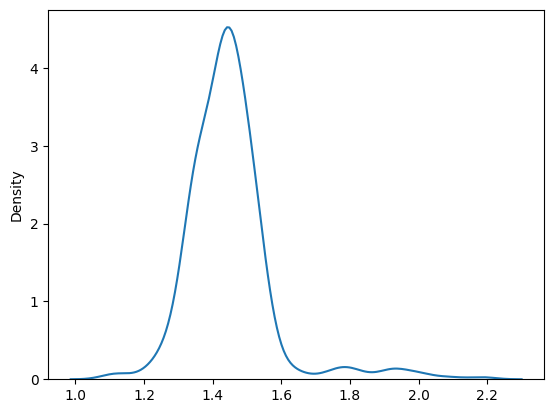

In [84]:
seaborn.kdeplot(maximum_differences_per_instance)

This plot shows that the most common difference in the interpretations of the two explainers falls between 1.4 and 1.5. Smaller and larger differences are less frequently observed across the instances.

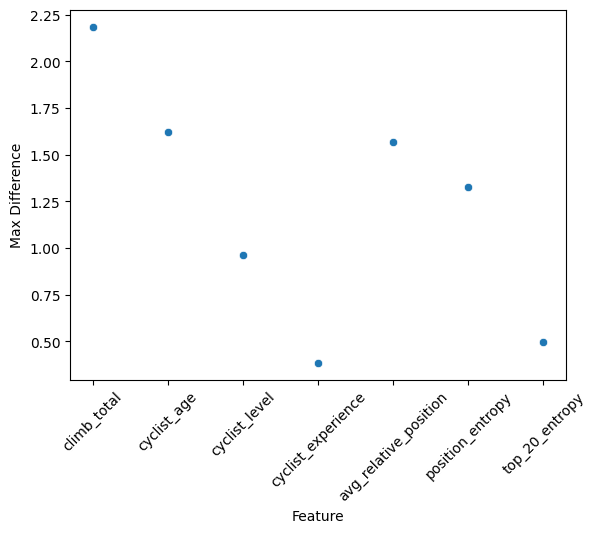

In [85]:
# Create a dataframte for better plotting
feature_differences = pd.DataFrame({
    'Feature': train_data.columns,
    'Max Difference': maximum_differences_per_feature
})

seaborn.scatterplot(data=feature_differences, x='Feature', y='Max Difference')
plt.xticks(rotation=45)
plt.show()

There is greater inconsistency between the two explanation methods for the "total climb" feature, which is considered important in both methods, while its importance is not as high in the native GBM model. In contrast, the inconsistency is lower for the "cyclist experience" feature, as it is rarely utilized by the model, which is reflected in its feature importance in the GBM model.

### Explanation analysis

Let analyze if some features generally more impactful then others adding noise to the feature and analyizing how much it impacts model's predctions 

Starting performances are:

In [86]:
pd.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.927083,0.321429,0.7575,0.624256,0.840778
recall,0.778426,0.631579,0.7575,0.705002,0.757500
f1-score,0.846276,0.426036,0.7575,0.636156,0.786392
support,343.000000,57.000000,0.7575,400.000000,400.000000


Let's sort features accordind to interventional explanation (we prefer this because match more with gbm importance)

In [87]:
interventional_explanations_df = pd.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
features_by_importance = interventional_explanations_df.abs().mean().sort_values(ascending=False).index

print("Features sorted by decreasing importance for interventional method:")
for feature in features_by_importance:
    print("-",feature)

Features sorted by decreasing importance for interventional method:
- climb_total
- avg_relative_position
- top_20_entropy
- position_entropy
- cyclist_level
- cyclist_experience
- cyclist_age


Let's construct a set of corrupted datasets where noise at different magnitudes is inserted into the original dataset

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_data_norm = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)

random_noise = np.random.rand(test_data_norm.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(2, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data_norm.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

Validate the model on the altered data

In [89]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, gbm_model.predict(corruption), output_dict=True, zero_division=0)

In [90]:
metric = "f1-score"
corruption_validation = pd.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["1"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["1"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,climb_total,0.2,0.252822,shap,-0.173214
1,climb_total,0.3,0.252822,shap,-0.173214
2,climb_total,0.4,0.252822,shap,-0.173214
3,climb_total,0.5,0.252822,shap,-0.173214
4,climb_total,0.6,0.252822,shap,-0.173214
5,climb_total,0.7,0.252822,shap,-0.173214
6,climb_total,0.8,0.252822,shap,-0.173214
7,climb_total,0.9,0.252822,shap,-0.173214
8,avg_relative_position,0.2,0.252822,shap,-0.173214
9,avg_relative_position,0.3,0.253394,shap,-0.172642


The results suggest that the model generalises poorly, as even small alterations in each features cause a significant drop in performance. This suggests that the model may be overly dependent on specific feature details, compromising the overall robustness of decisions. 

In [91]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                            count      mean       std       min       25%   
feature                                                                     
avg_relative_position         8.0  0.253682  0.000615  0.252822  0.253394   
climb_total                   8.0  0.252822  0.000000  0.252822  0.252822   
cyclist_age                   8.0  0.256598  0.005311  0.247031  0.255784   
cyclist_experience            8.0  0.252601  0.001230  0.251685  0.252252   
cyclist_level                 8.0  0.252111  0.000401  0.251685  0.251685   
position_entropy              8.0  0.254042  0.000717  0.252822  0.253394   
top_20_entropy                8.0  0.253537  0.000266  0.253394  0.253394   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
avg_relative_position  0.253394  0.254113  0.254545        8.0 -0.172354   
climb_total            0.252822  0.252822  0.252822        8.0 -0.173214   
cyclist_age            0.258765  0.259594  0.260870        8.0 -0.169437   
cyclist_experience     0.252252  0.252252  0.255605        8.0 -0.173435   
cyclist_level          0.252252  0.252252  0.252822        8.0 -0.173925   
position_entropy       0.254545  0.254545  0.254545        8.0 -0.171993   
top_20_entropy         0.253394  0.253537  0.253968        8.0 -0.172498   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
avg_relative_position  0.000615 -0.173214 -0.172642 -0.172642 -0.171923   
climb_total            0.000000 -0.173214 -0.173214 -0.173214 -0.173214   
cyclist_age            0.005311 -0.179005 -0.170252 -0.167271 -0.166442   
cyclist_experience     0.001230 -0.174350 -0.173783 -0.173783 -0.173783   
cyclist_level          0.000401 -0.174350 -0.174350 -0.173783 -0.173783   
position_entropy       0.000717 -0.173214 -0.172642 -0.171490 -0.171490   
top_20_entropy         0.000266 -0.172642 -0.172642 -0.172642 -0.172498   

                                 
                            max  
feature                          
avg_relative_position -0.171490  
climb_total           -0.173214  
cyclist_age           -0.165166  
cyclist_experience    -0.170430  
cyclist_level         -0.173214  
position_entropy      -0.171490  
top_20_entropy        -0.172067

In [92]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.2                     7.0  0.252417  0.001421  0.249412  0.252537  0.252822   
0.3                     7.0  0.252077  0.002283  0.247031  0.252252  0.252822   
0.4                     7.0  0.253786  0.002353  0.252252  0.252537  0.253394   
0.5                     7.0  0.254137  0.003106  0.251685  0.252537  0.253394   
0.6                     7.0  0.254137  0.003106  0.251685  0.252537  0.253394   
0.7                     7.0  0.254059  0.002498  0.251685  0.252537  0.253394   
0.8                     7.0  0.254051  0.002272  0.251685  0.252537  0.253968   
0.9                     7.0  0.254356  0.001918  0.252252  0.253108  0.253968   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.2              0.252822  0.253968        7.0 -0.173619  0.001421 -0.176624   
0.3              0.253394  0.253394        7.0 -0.173959  0.002283 -0.179005   
0.4              0.253394  0.258993        7.0 -0.172250  0.002353 -0.173783   
0.5              0.253970  0.260870        7.0 -0.171898  0.003106 -0.174350   
0.6              0.253970  0.260870        7.0 -0.171898  0.003106 -0.174350   
0.7              0.254545  0.259169        7.0 -0.171977  0.002498 -0.174350   
0.8              0.254545  0.258537        7.0 -0.171985  0.002272 -0.174350   
0.9              0.255075  0.257908        7.0 -0.171679  0.001918 -0.173783   

                                                         
                      25%       50%       75%       max  
noise_magnitude                                          
0.2             -0.173499 -0.173214 -0.173214 -0.172067  
0.3             -0.173783 -0.173214 -0.172642 -0.172642  
0.4             -0.173499 -0.172642 -0.172642 -0.167043  
0.5             -0.173499 -0.172642 -0.172066 -0.165166  
0.6             -0.173499 -0.172642 -0.172066 -0.165166  
0.7             -0.173499 -0.172642 -0.171490 -0.166867  
0.8             -0.173499 -0.172067 -0.171490 -0.167499  
0.9             -0.172928 -0.172067 -0.170960 -0.168128

In [93]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Define the metric to assess performance drop
metric = "f1-score"

# Initialize a list to store performance drops
performance_drops = []

# Get the original performance
original_performance = classification_report(test_labels, gbm_model.predict(test_data), output_dict=True, zero_division=0)
original_metric_value = original_performance["1"][metric]

# Iterate over each feature
for feature in test_data.columns:
    # Drop the feature from the training and test data
    train_data_dropped = train_data.drop(columns=[feature])
    test_data_dropped = test_data.drop(columns=[feature])
    
    # Train a new GBM model with the same parameters
    gbm_model_dropped = LGBMClassifier(**gbm_model.get_params())
    gbm_model_dropped.fit(train_data_dropped, train_labels.values.ravel())
    
    # Predict and assess performance
    test_predictions_dropped = gbm_model_dropped.predict(test_data_dropped)
    performance_dropped = classification_report(test_labels, test_predictions_dropped, output_dict=True, zero_division=0)
    dropped_metric_value = performance_dropped["1"][metric]
    
    # Calculate performance drop
    performance_drop = original_metric_value - dropped_metric_value
    performance_drops.append((feature, performance_drop))

# Create a dataframe to store the results
performance_drop_df = pd.DataFrame(performance_drops, columns=["Feature", "Performance Drop"])
performance_drop_df = performance_drop_df.sort_values(by="Performance Drop", ascending=False)
print(performance_drop_df)

                 Feature  Performance Drop
3     cyclist_experience         -0.126316
2          cyclist_level         -0.208333
6         top_20_entropy         -0.231579
1            cyclist_age         -0.252427
0            climb_total         -0.254902
4  avg_relative_position         -0.277778
5       position_entropy         -0.280702


By removing one feature at a time, we observe a significant drop in the F1-score for class 1. This indicates that eliminating even a single feature from the training set substantially impacts overall performance, particularly the model's ability to balance its predictions. Specifically, it diminishes the model's effectiveness in handling class 1.

## **LORE**

Support function

In [94]:
feature_indices = {
    'climb_total': 0,
    'cyclist_age': 1,
    'cyclist_level': 2,
    'cyclist_experience': 3,
    'avg_relative_position': 4,
    'position_entropy': 5,
    'top_20_entropy': 6
}

def format_counterfactual_explanation(explanation):
    formatted_explanation = []
    for rule in explanation:
        premises = " AND ".join([f"{condition['att']} {condition['op']} {(condition['thr']*scaler.scale_[feature_indices[condition["att"]]]) + scaler.mean_[feature_indices[condition["att"]]]}" for condition in rule['premise']])
        formatted_explanation.append(f"IF {premises} THEN {rule['class_name']} = {rule['cons']}")
    return formatted_explanation

def reverse_transform(record, var, mean):
    return record * var + mean

def normalize_premise(premise, feature_indices, scaler):
    return {
        'thr': reverse_transform(premise['thr'], scaler.scale_[feature_indices[premise["att"]]], scaler.mean_[feature_indices[premise["att"]]]),
        'att': premise['att'],
        'op': premise['op'],
        'is_continuous': premise['is_continuous']
    }

def format_explanation(explanation):
    explanation.expDict['rule']['premise'] = list(map(
        lambda x: normalize_premise(x, feature_indices, scaler),
        explanation.expDict['rule']['premise']
    ))

    explanation.expDict['crules'][0]['premise'] = list(map(
        lambda x: normalize_premise(x, feature_indices, scaler),
        explanation.expDict['crules'][0]['premise']
    ))
    
    return explanation


In [95]:
from xailib.explainers.lore_explainer import LoreTabularExplainer


explanation_algorithm = LoreTabularExplainer(gbm_model)
configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr": 0.1,
    "ngen": 100
}

train_data = StandardScaler().fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns=train_df.drop(columns=columns_to_drop).columns)
lore_train_data = pd.concat((train_data, train_labels), axis="columns")
explanation_algorithm.fit(lore_train_data, "top_20", config=configuration)

### Explaining a data from class 1, predicted as class 1

In [106]:
indexes = test_labels[(test_labels['top_20'] == 1) & test_prediction==1].index
print("Indexes in training data with both test and predicted label being 1:")
print(indexes.tolist())

Indexes in training data with both test and predicted label being 1:
[2, 15, 32, 34, 48, 62, 63, 65, 67, 83, 98, 103, 115, 119, 120, 133, 138, 155, 171, 177, 181, 188, 189, 193, 196, 221, 223, 240, 261, 316, 355, 357, 359, 373, 395, 399]


In [125]:
explanation = explanation_algorithm.explain(train_data.iloc[32].values)
explanation = format_explanation(explanation)

Extracting rules from the tree

In [126]:
rule = explanation.plotRules()

Extracting counterfactual rules from the tree

In [127]:
rule = explanation.plotCounterfactualRules()

Local Fidelity (accuracy of the model w.r.t. the model, computed on the generated neighborhood)

In [128]:
explanation.expDict["fidelity"]

0.990522369673229

### Explaining a data from class 0, predicted as class 0

In [129]:
indexes = test_labels[(test_labels['top_20'] == 0) & test_prediction==0].index
print("Indexes in training data with both test and predicted label being 0:")
print(indexes.tolist())
young_cyclists_indexes = test_data.loc[indexes][test_data['cyclist_age'] < 21].index
print("Indexes with cyclist_age < 21:")
print(young_cyclists_indexes.tolist())

Indexes in training data with both test and predicted label being 0:
[1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 60, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76, 77, 78, 80, 81, 82, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 98, 99, 100, 101, 103, 104, 105, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 124, 125, 126, 127, 128, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 151, 152, 154, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 171, 172, 174, 175, 176, 177, 178, 181, 182, 183, 184, 185, 187, 188, 189, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 236, 238, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 250, 25

In [130]:
explanation = explanation_algorithm.explain(train_data.iloc[399].values)
explanation = format_explanation(explanation)

Extracting rules from the tree

In [131]:
rule = explanation.plotRules()

Extracting counterfactual rules from the tree

In [132]:
rule = explanation.plotCounterfactualRules()

Local Fidelity (accuracy of the model w.r.t. the model, computed on the generated neighborhood)

In [133]:
explanation.expDict["fidelity"]

0.9982939957557407